[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/b-koopman/VLM_inference/blob/main/VLM_inference_pt2_performance.ipynb)


# VLM (Vision-Language Models) Inference (Part 2: Performance Metrics)

This part will focus on inputs and outputs from LLMs (especially VLMs) and how they relate to performance.  We'll roughly touch on metrics like TTFT/TPOT and how these relate to inference engines like vLLM or TRT-LLM, though we won't cover those in depth for this part.

## Architecture Review (From Part 1)

Recall from [Part1: Architecture](https://github.com/b-koopman/VLM_inference/blob/main/VLM_inference_pt1_architectures.ipynb) that the architecture for VLMs includes both the "LLM" component, and the "Image Encoding component".  This even holds true for "native multimodal" models like LLaMA 4, the image still needs to be passed through a ViT to be transformed into embeddings.

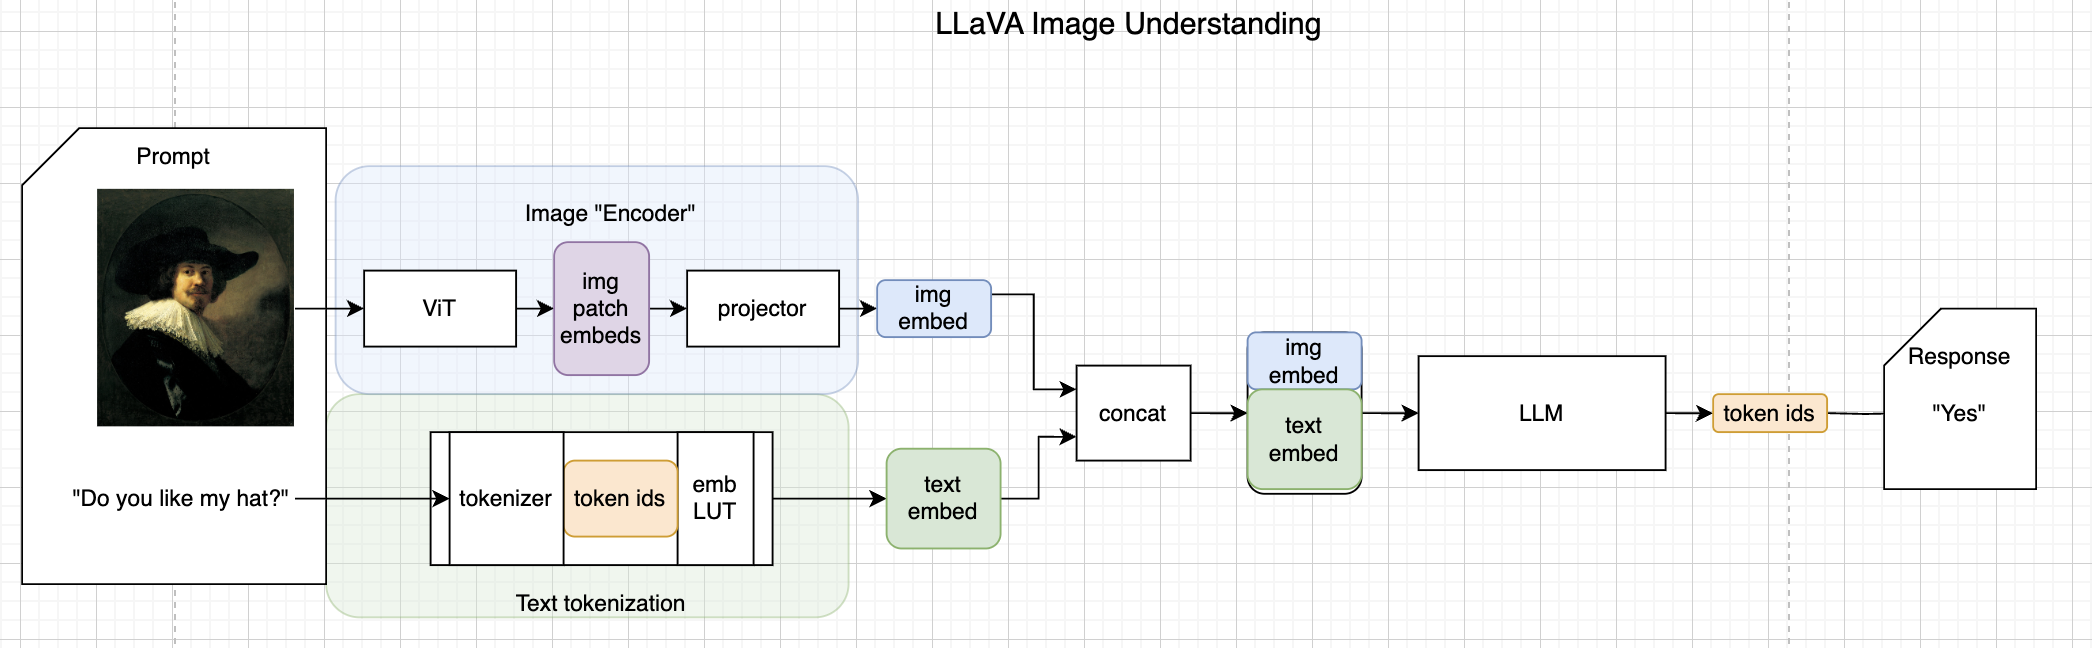

### LLM Latency/performance components

First, let's talk about terminology to define the vocabulary we will use during measurement.

- TTFT (Time To First Token) - `input tok/s`
  - How long it takes from calling the model for the first token to be produced in the output.
  - Encompasses "Encoding Latency"
  - *Performance Impact*: This usually dominates latency/throughput for shorter responses, like multiple choice VQA tasks or classification.
- TPOT (Time Per Output Token) - `output tok/s`
  - How long it takes for a single token to be generated.  This means that the longer an output sequence is (e.g. the more tokens generated per prompt) the longer it takes. example -> you write a 1000 word document, this might roughly be 2500 tokens, at a resonable 100 output tok/s, this is `2500 / 100 = 25 seconds`. If you double that, it will take `30 seconds` for the entire query to complete.
  - *Performance Impact*: For longer generations, latency, and overall prompt throughput will be governed by TPOT
- Prompt / input token length
  - The input to the model, in the case of VLMs
  - *Performance Impact*: In a multimodal VLM context, this influences the latency of image encoding, which is proportional to the number of images to be encoded.
- Context window length
  - The maximum number of input tokens an LLM can handle.
  - This is limited by 1) training context and 2) any inference techniques that can be used to extend the context length like rotary embeddings. **TODO b-koopman: link GLM4.5-V or Qwen2.5VL Tech Report discussing native trained context vs. extended**


#### Review for Tokens
For a review of what "Tokens" are and how they relate to input/output, and how images are represented as tokens, see [Part1](https://github.com/b-koopman/VLM_inference/blob/main/VLM_inference_pt1_architectures.ipynb)

#### Performance Engineering Reference

As supplemental material, be sure to also check out the [Databricks performance engineering best practices document](https://www.databricks.com/blog/llm-inference-performance-engineering-best-practices), which addresses some of the above metrics, and more in-depth discussion of measurement.

### Composition of Latency

While the [Databricks guide](https://www.databricks.com/blog/llm-inference-performance-engineering-best-practices) defines latency as


$$
Latency = TTFT + TPOT * tok_{out}
$$

Where $tok_{out}$ is total output tokens.



However, in a VLM setting, it is helpful to think of this more as a composition of encoding latencies, as well as LLM latency.

$$
Latency = Encode_{image}( img_{in} ) + Tokenization_{text} + Encode_{LLM} + TPOT * tok_{out}
$$

where $Encode_{image}( img_{in} )$ is a function describing the encoding latency of $img_{in}$ separate images.

Text tokenization is negligible in this scenario (as we'll see below) so this can be more simply expressed as

$$
Latency = Encode_{images} + Encode_{LLM} + TPOT * tok_{out}
$$

### Measuring latency for real life

Let's focus on a smaller llava implemenation, so we can fit it on a cheaper, more accessible GPU for the demo/exploration.

Specifically: [llava-hf/llava-onevision-qwen2-0.5b-ov-hf](https://huggingface.co/llava-hf/llava-onevision-qwen2-0.5b-ov-hf)


Later, we'll discuss how this transfers to larger models.

In [1]:
!pip install bitsandbytes
!pip install torch torchvision torchaudio
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 38.7 MB/s eta 0:00:00


In [2]:
import requests
from PIL import Image
import time

import torch
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration, BitsAndBytesConfig

model_id = "llava-hf/llava-onevision-qwen2-7b-ov-hf"

# Define the quantization configuration
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

model = LlavaOnevisionForConditionalGeneration.from_pretrained(
    model_id,
    # dtype=torch.float16, # dtype is handled by quantization_config
    low_cpu_mem_usage=True,
    # load_in_4bit=True, # deprecated
    quantization_config=quantization_config,
).to(0)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/126 [00:00<?, ?B/s]

In [3]:
processor = AutoProcessor.from_pretrained(model_id)

processor_config.json:   0%|          | 0.00/178 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/621 [00:00<?, ?B/s]

In [4]:
# Define a chat history and use `apply_chat_template` to get correctly formatted prompt
# Each value in "content" has to be a list of dicts with types ("text", "image")
conversation = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text": "What are these?"},
          {"type": "image"},
        ],
    },
]
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)


In [5]:
image_file = "http://images.cocodataset.org/val2017/000000039769.jpg"
raw_image = Image.open(requests.get(image_file, stream=True).raw)
inputs = processor(images=[raw_image], text=prompt, return_tensors='pt').to(0, torch.float16)

In [6]:
#@title LLM Streaming Timeline Explorer {display-mode: "form"}
#@markdown Let's visualize the TTFT and TPOT in realtime.
#@markdown Click the public URL below to visualize.
!pip install plotly gradio -q

import gradio as gr
import time
import threading
from datetime import datetime
import plotly.graph_objects as go
import torch
from transformers import TextIteratorStreamer
import numpy as np
from PIL import Image
import requests
from io import BytesIO

class LLMTimingVisualizer:
    def __init__(self, model, processor):
        self.model = model
        self.processor = processor
        self.timeline_data = []
        self.start_time = None
        self.stop_generation = False

    def reset_timeline(self):
        """Reset timeline for new inference"""
        self.timeline_data = []
        self.start_time = time.time()
        self.stop_generation = False

    def add_phase(self, phase_name, start_offset, end_offset):
        """Add a phase to the timeline"""
        self.timeline_data.append({
            'phase': phase_name,
            'start': start_offset,
            'end': end_offset,
            'duration': end_offset - start_offset
        })

    def create_timeline_plot(self):
        """Create Plotly timeline visualization"""
        if not self.timeline_data:
            fig = go.Figure()
            fig.update_layout(
                title="LLM Inference Timeline - Ready to generate",
                xaxis_title="Time (seconds)",
                height=300,
                margin=dict(l=150, r=50, t=60, b=50),
            )
            return fig

        fig = go.Figure()

        # Color mapping for different phases
        colors = {
            'First Token (TTFT)': '#45B7D1',
            'Token Generation': '#FFEAA7',
            'Complete': '#96CEB4'
        }

        # Add bars for each phase
        for i, phase in enumerate(self.timeline_data):
            fig.add_trace(go.Scatter(
                x=[phase['start'], phase['end']],
                y=[i, i],
                mode='lines+markers',
                line=dict(
                    color=colors.get(phase['phase'], '#95A5A6'),
                    width=25
                ),
                marker=dict(size=12, color=colors.get(phase['phase'], '#95A5A6')),
                name=phase['phase'],
                hovertemplate=f"<b>{phase['phase']}</b><br>" +
                            f"Duration: {phase['duration']:.3f}s<br>" +
                            f"Start: {phase['start']:.3f}s<br>" +
                            f"End: {phase['end']:.3f}s<extra></extra>"
            ))

        # Update layout
        total_time = max([p['end'] for p in self.timeline_data]) if self.timeline_data else 1
        fig.update_layout(
            title={
                'text': "LLM Inference Timeline",
                'font': {'size': 16, 'color': '#2E86AB'}
            },
            xaxis_title="Time (seconds)",
            yaxis=dict(
                tickmode='array',
                tickvals=list(range(len(self.timeline_data))),
                ticktext=[phase['phase'] for phase in self.timeline_data],
                showgrid=False
            ),
            showlegend=False,
            height=300,
            margin=dict(l=150, r=50, t=80, b=50),
            xaxis=dict(
                range=[0, max(total_time * 1.1, 1)],
                showgrid=True,
                gridcolor='lightgray'
            ),
            plot_bgcolor='white',
            font=dict(size=12)
        )

        return fig

    def generate_with_timing_progressive(self, prompt, image=None, max_new_tokens=256):
        """Generate with progressive TTFT visualization"""
        self.reset_timeline()

        # Phase 1: Show encoding progress
        process_start = time.time()

        # Yield initial state
        yield "⏳ Encoding inputs...", self.create_timeline_plot(), "🔄 Starting encoding process..."

        if image is not None:
            conversation = [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt},
                        {"type": "image"},
                    ],
                },
            ]
        else:
            conversation = [
                {
                    "role": "user",
                    "content": [{"type": "text", "text": prompt}],
                },
            ]

        # Apply chat template
        prompt_text = self.processor.apply_chat_template(conversation, add_generation_prompt=True)

        # Show progress during encoding
        encoding_start = time.time()
        if image is not None:
            yield "🖼️ Processing image...", self.create_timeline_plot(), "🔄 Encoding image and text..."
            inputs = self.processor(text=prompt_text, images=image, return_tensors="pt").to(self.model.device)
        else:
            yield "📝 Processing text...", self.create_timeline_plot(), "🔄 Encoding text..."
            inputs = self.processor(text=prompt_text, return_tensors="pt").to(self.model.device)

        # Update with encoding complete
        encoding_end = time.time()
        encoding_time = encoding_end - process_start

        # Start showing TTFT progress
        self.add_phase("First Token (TTFT)", 0, encoding_time)
        yield "🧠 Model thinking...", self.create_timeline_plot(), "⏳ Waiting for first token..."

        # Phase 2: Start generation
        streamer = TextIteratorStreamer(
            self.processor.tokenizer,
            timeout=30.0,
            skip_prompt=True,
            skip_special_tokens=True
        )

        generation_kwargs = {
            **inputs,
            "streamer": streamer,
            "max_new_tokens": max_new_tokens,
            "do_sample": True,
            "temperature": 0.7,
            "pad_token_id": self.processor.tokenizer.eos_token_id
        }

        # Start generation thread and monitor for TTFT updates
        generation_thread = threading.Thread(target=self.model.generate, kwargs=generation_kwargs)
        generation_thread.start()

        tokens = []
        token_times = []
        first_token_time = None
        last_time = encoding_end
        generated_text = ""

        # Create a separate thread to periodically update TTFT while waiting
        def update_ttft_while_waiting():
            while first_token_time is None and generation_thread.is_alive():
                current_wait = time.time() - encoding_end
                total_ttft = (encoding_end - process_start) + current_wait
                if self.timeline_data:
                    self.timeline_data[0]['end'] = total_ttft
                    self.timeline_data[0]['duration'] = total_ttft
                time.sleep(0.1)  # Update every 100ms

        # Start TTFT monitoring thread
        ttft_thread = threading.Thread(target=update_ttft_while_waiting)
        ttft_thread.daemon = True
        ttft_thread.start()

        # Show periodic updates while waiting for first token
        last_update = time.time()

        try:
            for token in streamer:
                current_time = time.time()

                if first_token_time is None:
                    # First token received!
                    first_token_time = current_time
                    ttft = first_token_time - process_start

                    # Update TTFT phase with final time
                    self.timeline_data[0]['end'] = ttft
                    self.timeline_data[0]['duration'] = ttft

                    generated_text = token
                    yield f"✨ First token received!\n{generated_text}", self.create_timeline_plot(), f"🎉 **TTFT**: {ttft:.3f}s\n🔄 Now generating tokens..."

                    last_time = current_time
                else:
                    # Subsequent tokens - stream them live
                    token_times.append(current_time - last_time)
                    generated_text += token

                    # Update token generation phase
                    if len(self.timeline_data) == 1:
                        self.add_phase("Token Generation",
                                     first_token_time - process_start,
                                     current_time - process_start)
                    else:
                        self.timeline_data[1]['end'] = current_time - process_start
                        self.timeline_data[1]['duration'] = (current_time - process_start) - self.timeline_data[1]['start']

                    # Yield every few tokens or every 0.5 seconds
                    if len(tokens) % 3 == 0 or (current_time - last_update) > 0.5:
                        current_stats = self.get_progressive_stats(token_times, len(tokens) + 1)
                        yield generated_text, self.create_timeline_plot(), current_stats
                        last_update = current_time

                    last_time = current_time

                tokens.append(token)

                if self.stop_generation:
                    break

        except Exception as e:
            yield f"❌ Error: {str(e)}", self.create_timeline_plot(), f"Generation failed: {str(e)}"
            return

        # Wait for completion
        generation_thread.join()

        # Final completion
        final_time = time.time()
        self.add_phase("Complete", final_time - process_start - 0.01, final_time - process_start)

        final_stats = self.get_final_stats(token_times)
        yield generated_text, self.create_timeline_plot(), final_stats

    def get_progressive_stats(self, token_times, token_count):
        """Get stats during generation"""
        stats = []

        if self.timeline_data:
            ttft_phase = self.timeline_data[0]
            stats.append(f"⚡ **TTFT**: {ttft_phase['duration']:.3f}s")

        if token_times:
            avg_tpot = np.mean(token_times)
            tokens_per_sec = 1/avg_tpot if avg_tpot > 0 else 0
            stats.append(f"🔥 **Current TPOT**: {avg_tpot:.4f}s")
            stats.append(f"🚀 **Tokens/sec**: {tokens_per_sec:.1f}")
            stats.append(f"📊 **Tokens generated**: {token_count}")

        stats.append("🔄 **Status**: Generating...")
        return "\n".join(stats)

    def get_final_stats(self, token_times):
        """Get comprehensive performance statistics"""
        if not self.timeline_data:
            return "No generation completed"

        stats = []

        # Find phases
        ttft_phase = next((p for p in self.timeline_data if "TTFT" in p['phase']), None)
        token_gen_phase = next((p for p in self.timeline_data if "Token Generation" in p['phase']), None)

        if ttft_phase:
            stats.append(f"⚡ **TTFT**: {ttft_phase['duration']:.3f}s")

        if token_gen_phase and token_times:
            avg_tpot = np.mean(token_times) if token_times else 0
            tokens_per_sec = 1/avg_tpot if avg_tpot > 0 else 0
            stats.append(f"🔥 **Avg TPOT**: {avg_tpot:.4f}s")
            stats.append(f"🚀 **Tokens/sec**: {tokens_per_sec:.1f}")
            stats.append(f"📊 **Total tokens**: {len(token_times)}")

            # Additional stats
            if len(token_times) > 1:
                stats.append(f"📈 **Min TPOT**: {min(token_times):.4f}s")
                stats.append(f"📉 **Max TPOT**: {max(token_times):.4f}s")

        total_time = max([p['end'] for p in self.timeline_data]) if self.timeline_data else 0
        stats.append(f"⏱️ **Total time**: {total_time:.3f}s")

        return "\n".join(stats)

    def stop(self):
        self.stop_generation = True

# Load default cat image
def load_default_image():
    try:
        response = requests.get("http://images.cocodataset.org/val2017/000000039769.jpg")
        image = Image.open(BytesIO(response.content))
        return image
    except:
        return None

# Create visualizer
visualizer = LLMTimingVisualizer(model, processor)

def run_generation_progressive(prompt, image, max_tokens):
    """Run generation with true real-time streaming updates"""
    if not prompt.strip():
        yield "Please enter a prompt", go.Figure(), "❌ No prompt provided"
        return

    # Use default image if none provided
    if image is None:
        image = load_default_image()

    # Stream each update as it happens
    for text, plot, stats in visualizer.generate_with_timing_progressive(prompt, image, max_tokens):
        yield text, plot, stats

def stop_generation():
    visualizer.stop()
    return "⏹️ Generation stopped"

# Create interface optimized for Colab
with gr.Blocks(title="LLM Timing Visualizer", theme=gr.themes.Soft()) as demo:
    gr.Markdown("""
    # 🚀 LLM Performance Analyzer

    Analyze your LLaVA model's performance with detailed timing breakdown:
    - **TTFT**: Time to First Token (includes image processing)
    - **Token Generation**: Per-token generation timing
    - **Performance Metrics**: Tokens/sec, TPOT statistics
    """)

    with gr.Row():
        with gr.Column(scale=3):
            prompt_input = gr.Textbox(
                label="💬 Prompt",
                placeholder="What objects do you see in this image?",
                value="What objects do you see in this image? Talk like a pirate!",
                lines=2
            )

            with gr.Row():
                with gr.Column():
                    image_input = gr.Image(
                        label="🖼️ Upload Image (auto-loads cat image)",
                        type="pil",
                        height=250
                    )

                with gr.Column():
                    max_tokens = gr.Slider(
                        label="📝 Max New Tokens",
                        minimum=50,
                        maximum=400,
                        value=150,
                        step=25
                    )

                    stats_display = gr.Markdown(
                        value="Click **Generate** to see performance metrics",
                        label="📊 Performance Stats"
                    )

            with gr.Row():
                generate_btn = gr.Button("🎯 Generate & Analyze", variant="primary", size="lg")
                stop_btn = gr.Button("⏹️ Stop", variant="secondary")

    # Timeline visualization
    timeline_plot = gr.Plot(label="⏱️ Inference Timeline")

    # Generated text
    output_text = gr.Textbox(
        label="🤖 Generated Text",
        lines=6,
        max_lines=10,
        show_copy_button=True
    )

    # Load default image on startup
    demo.load(
        fn=load_default_image,
        outputs=image_input
    )

    # Event handlers
    generate_btn.click(
        fn=run_generation_progressive,
        inputs=[prompt_input, image_input, max_tokens],
        outputs=[output_text, timeline_plot, stats_display]
    )

    stop_btn.click(
        fn=stop_generation,
        outputs=stats_display
    )

    # Examples
    gr.Examples(
        examples=[
            ["Describe what you see in this image in detail", 200],
            ["What are these cats doing? Write like a nature documentary", 180],
            ["Tell me a short story about these sleeping cats", 250],
        ],
        inputs=[prompt_input, max_tokens]
    )

# Launch with proper Colab settings - link only
print("🚀 Launching LLM Performance Analyzer...")
print("=" * 50)

try:
    demo.launch(
        share=True,
        debug=False,
        quiet=True,
        show_error=True,
        inbrowser=False,
        inline=False,
        prevent_thread_lock=True  # Prevents embedding in Colab
    )
    print("\n✅ Interface launched successfully!")
    print("🌐 Click the public URL above to open the analyzer")
    print("💡 For best experience, open in a new browser tab")
except Exception as e:
    print(f"❌ Launch error: {e}")
    print("💡 Try restarting the runtime and running again")

🚀 Launching LLM Performance Analyzer...
* Running on public URL: https://337e22ccb80cdcf96c.gradio.live

✅ Interface launched successfully!
🌐 Click the public URL above to open the analyzer
💡 For best experience, open in a new browser tab


You should see a gradio interface that looks like this, and allows you to visualize response latencies: 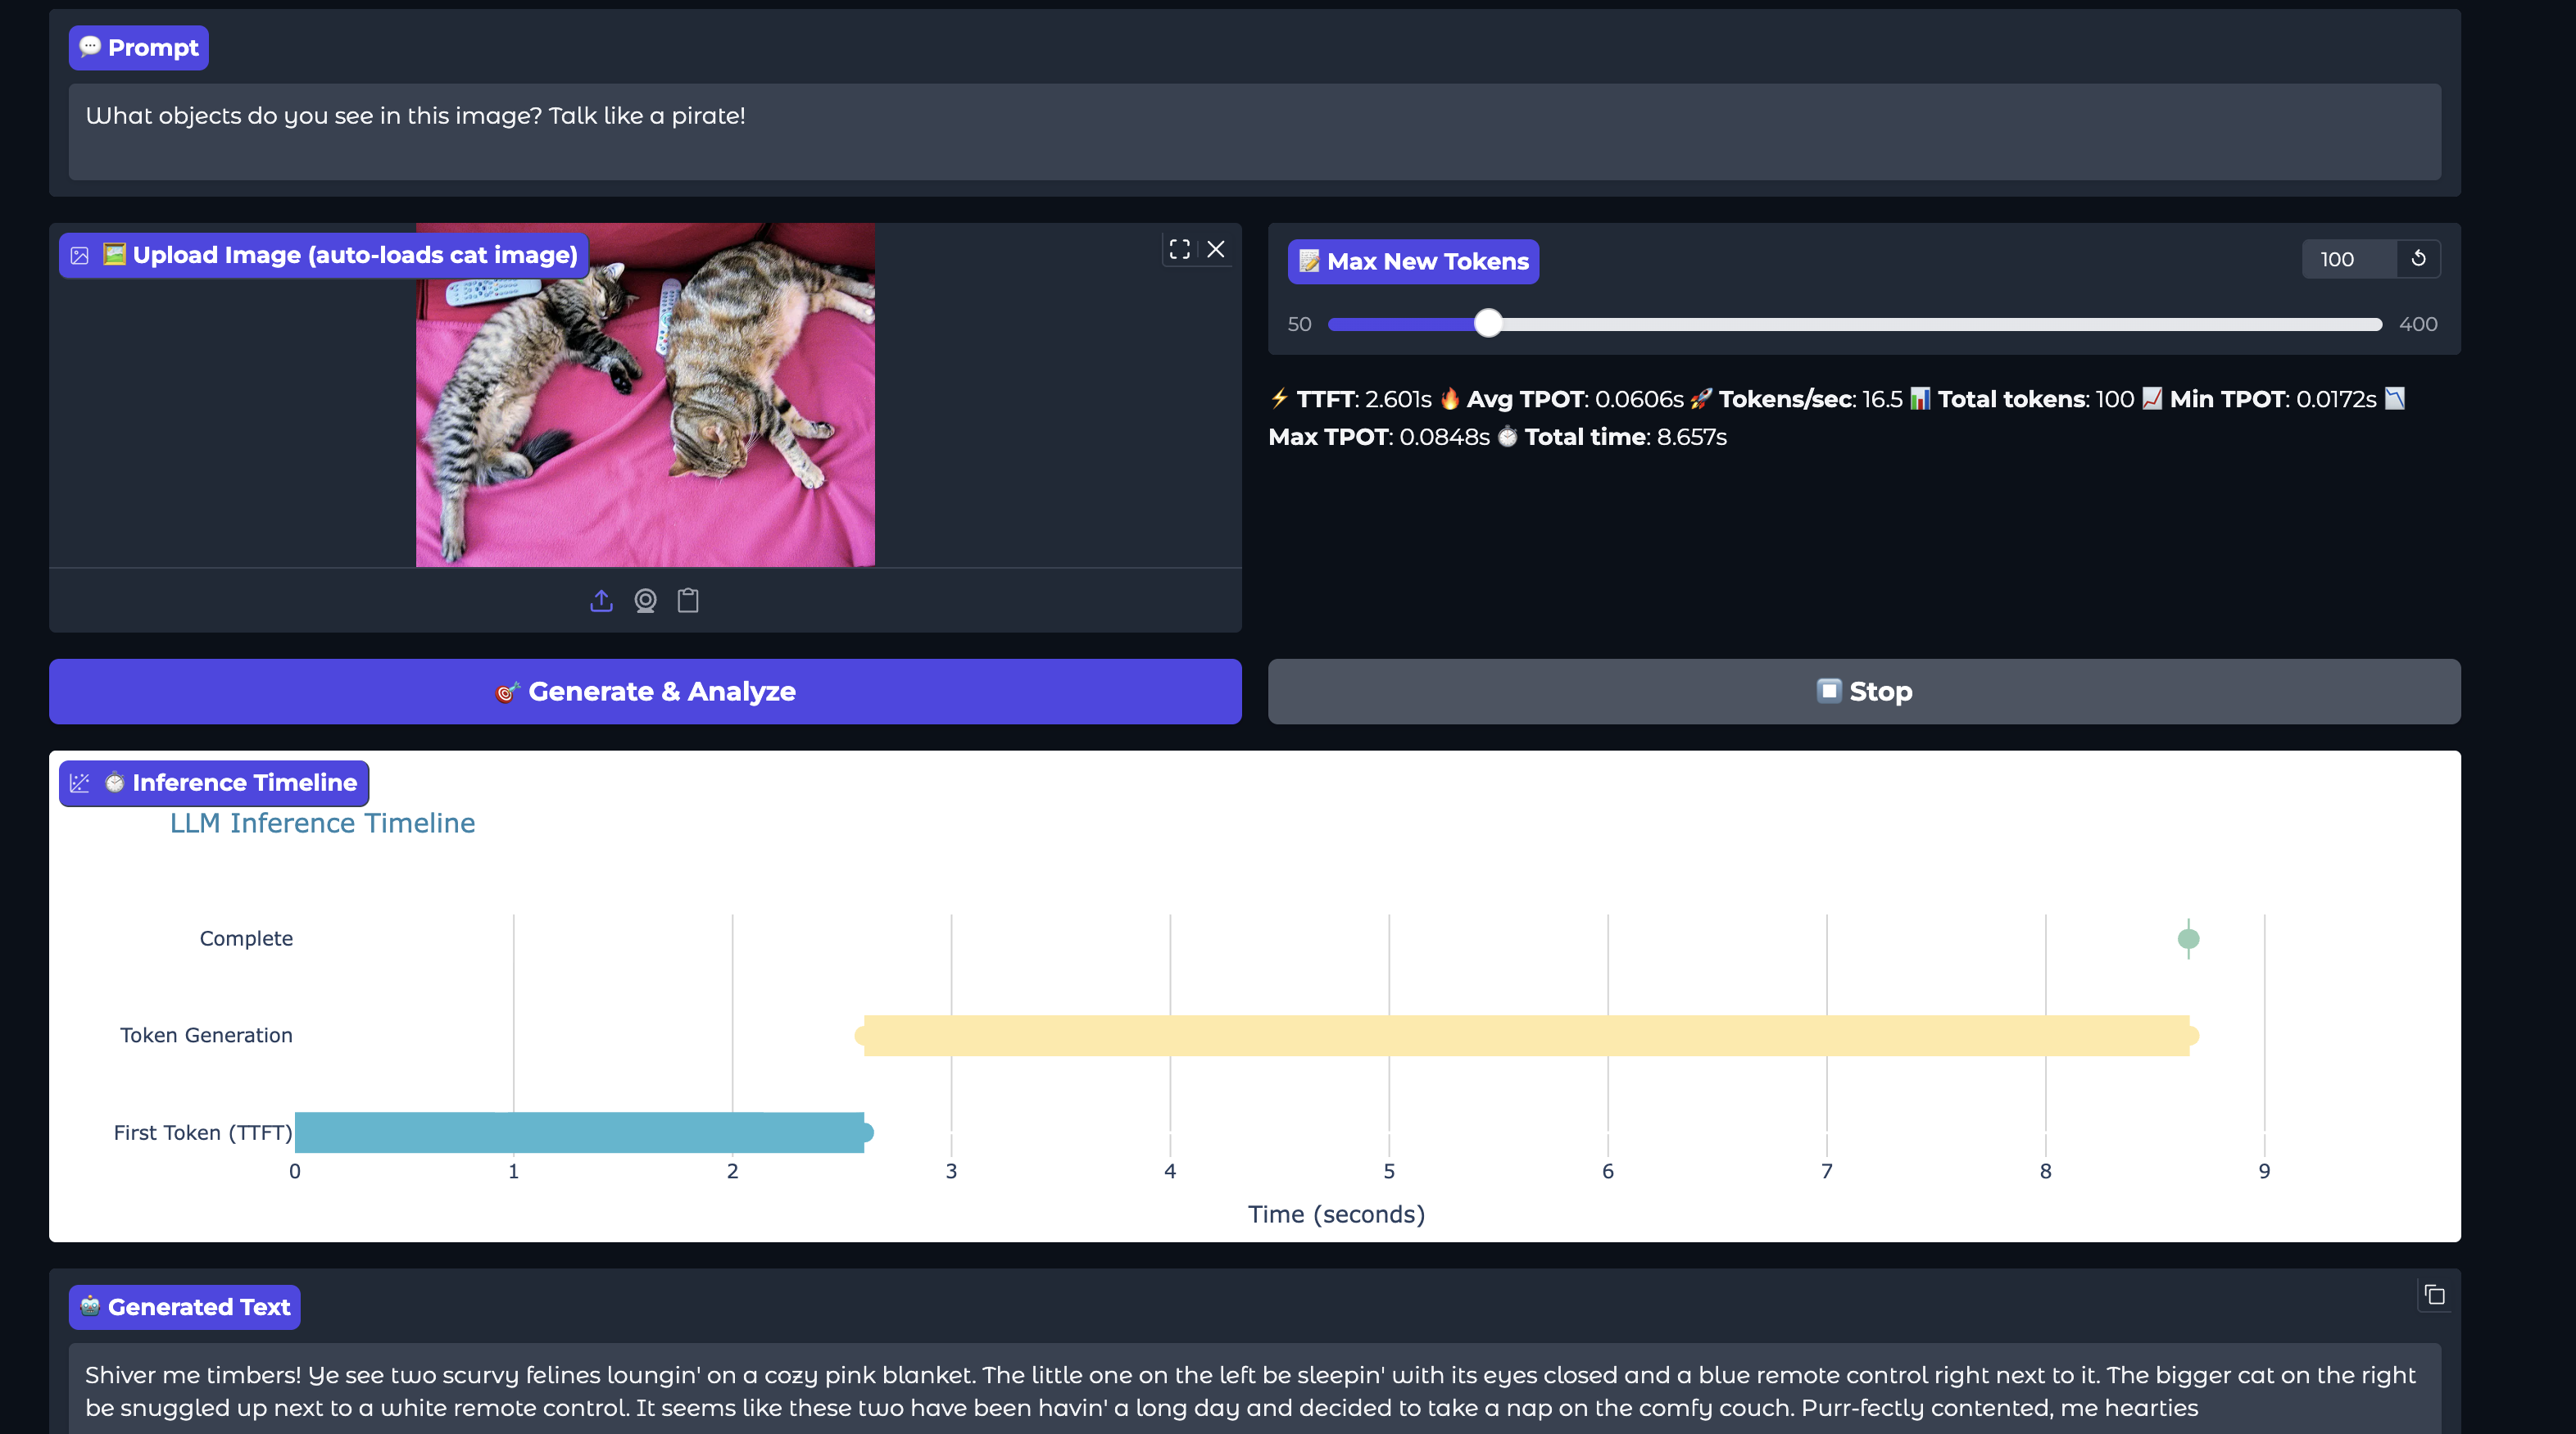

You can look more deeply at the above dashboard code, but this is really a pretty interface around streaming generation, which you can also call, and instrument yourself:

```
        streamer = TextIteratorStreamer(
            self.processor.tokenizer,
            timeout=30.0,
            skip_prompt=True,
            skip_special_tokens=True
        )
        
        generation_kwargs = {
            **inputs,
            "streamer": streamer,
            "max_new_tokens": max_new_tokens,
            "do_sample": True,
            "temperature": 0.7,
            "pad_token_id": self.processor.tokenizer.eos_token_id
        }
        
        # vvvvv GENERATE CALL IS HERE! vvvvv
        generation_thread = threading.Thread(target=self.model.generate, \
                                              kwargs=generation_kwargs)
        generation_thread.start()
```

### Compute TTFT with an image
First, we'll call the model with: 1 image, relatively short text input, and `max_new_tokens=1`, this way we know that we will only produce the first token, and by definition our latency

NOTE: max output tokens can be configured during the call to the model via the `model.generate(` call, generallly this can be configured at call-time, such also when calling the Fireworks Inference API **TODO b-koopman add link to Fireworks API**

In [7]:
input_ids_len = inputs.input_ids.shape[-1]
print(f"Prompt with image is {input_ids_len} tokens long.")

Prompt with image is 2941 tokens long.


In [8]:
output = model.generate(**inputs, max_length=input_ids_len+1, pad_token_id=processor.tokenizer.eos_token_id, do_sample=False)
print(processor.decode(output[0][input_ids_len:], skip_special_tokens=True))

cat


In [9]:
# output token length is input_len + output_len, see that we have created a single token, e.g. "cat"
print(f"Output Token Length: {output[0].shape[-1] - input_ids_len}")

Output Token Length: 1


In [10]:
# Warmup
_ = model.generate(**inputs, max_length=input_ids_len+1, pad_token_id=processor.tokenizer.eos_token_id, do_sample=False)

In [11]:
multimodal_ttft = 0
for _ in range(10):
  start_time = time.time()
  _ = model.generate(**inputs, max_length=input_ids_len+1, pad_token_id=processor.tokenizer.eos_token_id, do_sample=False)
  multimodal_ttft += time.time() - start_time
multimodal_ttft /= 10
print(f"TTFT With Image: {multimodal_ttft} seconds")

TTFT With Image: 0.2951062679290771 seconds


### Compute Image Encoding "Tokenization" Latency

Same prompt as before, but without the image. In order to do this, we want to pass the same number of input tokens to the LLM, but from text, not images, this let's us isolate the image encoding latency specifically.


NOTE the output will be a bit garbage, since it isn't conditioned on an actual image, but from a latency perspective it is identical to a semantically relevant answer.

In [12]:

def generate_prompt(input_ids_len:int):
  # Generate arbitrary text with a length of input_ids_len tokens
  # We can repeat a simple sentence until the token length is approximately input_ids_len
  arbitrary_text = "Write me a poem like a pirate "
  generated_text = "Initial text. " # Initialize with a small piece of text
  while processor(text=generated_text, return_tensors='pt').input_ids.shape[-1] < input_ids_len:
      generated_text += arbitrary_text

  # Trim the text if it exceeds the desired token length
  input_ids = processor(text=generated_text, return_tensors='pt').input_ids
  if input_ids.shape[-1] > input_ids_len:
      # Decode and re-encode to get closer to the exact token length
      generated_text = processor.decode(input_ids[0][:input_ids_len], skip_special_tokens=True)

  input_ids = processor(text=generated_text, return_tensors='pt').input_ids
  print(f"Generated text with {input_ids_len} tokens:")
  print(generated_text)
  assert(input_ids.shape[-1] == input_ids_len)
  return generated_text

In [13]:

# Define a chat history and use `apply_chat_template` to get correctly formatted prompt
# Each value in "content" has to be a list of dicts with types ("text", "image")
conversation = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text": generate_prompt(input_ids_len)},
        ],
    },
]
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
inputs = processor(images=None, text=prompt, return_tensors='pt').to(0, torch.float16)

Generated text with 2941 tokens:
Initial text. Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a 

In [14]:
input_ids_len = inputs.input_ids.shape[-1]
print(f"Prompt with only text is {input_ids_len} tokens long.")

Prompt with only text is 2948 tokens long.


In [15]:
output = model.generate(**inputs, max_length=input_ids_len+1, pad_token_id=processor.tokenizer.eos_token_id,  do_sample=False)
print(processor.decode(output[0][input_ids_len:], skip_special_tokens=True))

a


In [16]:
# warmup
_ = model.generate(**inputs, max_length=input_ids_len+1, pad_token_id=processor.tokenizer.eos_token_id, do_sample=False)

In [17]:
textonly_ttft = 0
for _ in range(10):
  start_time = time.time()
  _ = model.generate(**inputs, max_length=input_ids_len+1, pad_token_id=processor.tokenizer.eos_token_id, do_sample=False)
  textonly_ttft += time.time() - start_time
textonly_ttft /= 10
print(f"TTFT With Text Only: {textonly_ttft} seconds")

TTFT With Text Only: 0.24300720691680908 seconds


In [18]:
print(f"Image Encoding Latency for a single image is {multimodal_ttft - textonly_ttft} seconds")

Image Encoding Latency for a single image is 0.05209906101226805 seconds


### Time Per Output Token

Let's meaningfully increase output length.  We can use this to calculate TPOT (e.g. $TPOT = (Latency - TTFT) / tok$, so we can derive this with our prior TTFT calculation.

In [19]:
textonly_latency = 0
for _ in range(10):
  start_time = time.time()
  output = model.generate(**inputs, max_length=input_ids_len+512, pad_token_id=processor.tokenizer.eos_token_id, do_sample=False)
  textonly_latency += time.time() - start_time
textonly_latency /= 10
output_tokens = output[0].shape[-1] - input_ids_len
print(f"Avg. Text Only Latency: {textonly_latency} seconds")

Avg. Text Only Latency: 0.4356973171234131 seconds


In [20]:
# Calculate TPOT
tpot = (textonly_latency - textonly_ttft) / output_tokens
print(f"TPOT: {tpot} seconds per token")

TPOT: 0.048172527551651 seconds per token


#### Observe how TPOT meaningfully increases with input token length

In [21]:

def generate_inputs(input_ids_len:int):
  conversation = [
      {

        "role": "user",
        "content": [
            {"type": "text", "text": generate_prompt(input_ids_len)},
          ],
      },
  ]
  prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
  inputs = processor(images=None, text=prompt, return_tensors='pt').to(0, torch.float16)
  return inputs

In [22]:
PROFILE_ITERATIONS = 10

In [23]:
request_latency = {}
for input_ids_len in [32, 64, 128, 512, 1024, 2048, 8192]:
  output_ids_len = 128
  inputs = generate_inputs(input_ids_len)
  duration_sec = 0
  for _ in range(PROFILE_ITERATIONS):
    start_time = time.time()
    _ = model.generate(**inputs, min_length=input_ids_len + output_ids_len, max_length=input_ids_len + output_ids_len, pad_token_id=processor.tokenizer.eos_token_id, do_sample=False)
    duration_sec += time.time() - start_time
  duration_sec /= PROFILE_ITERATIONS
  request_latency[input_ids_len] = duration_sec

Generated text with 32 tokens:
Initial text. Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate 
Generated text with 64 tokens:
Initial text. Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like
Generated text with 128 tokens:
Initial text. Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Write me a poem like a pirate Wr

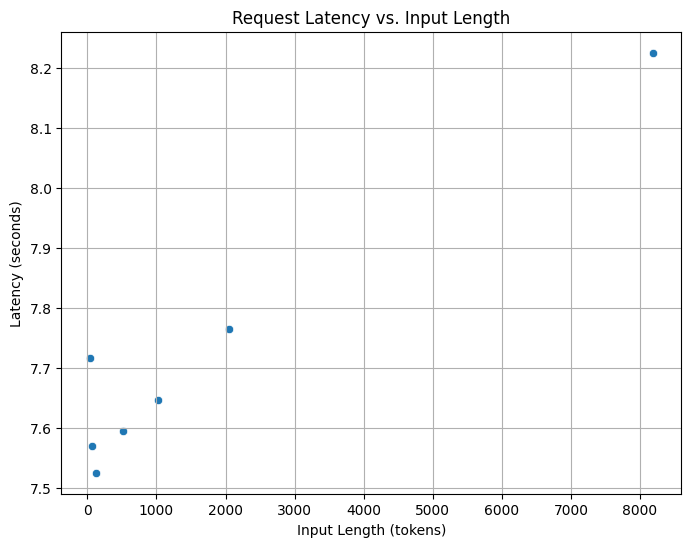

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert the request_latency dictionary to a pandas DataFrame for easier plotting
request_latency_df = pd.DataFrame(list(request_latency.items()), columns=['Input Length', 'Latency (sec)'])

# Create a scatter plot using seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=request_latency_df, x='Input Length', y='Latency (sec)')
plt.title('Request Latency vs. Input Length')
plt.xlabel('Input Length (tokens)')
plt.ylabel('Latency (seconds)')
plt.grid(True)
plt.show()

### Request Batching

We already talked a bit in [Part 1](https://colab.research.google.com/github/b-koopman/VLM_inference/blob/main/VLM_inference_pt1_architectures.ipynb) about image batching (e.g. inference on multiple images in the same call). This also can apply to prompts or inputs.


Let's see how this scales.  For batching, we'll look at tok/sec and prompt/seq in addition to overall request latency.  This is important, since there is a classic latency/throughput tradeoff with LLM inference.


Note: In this case we are using "tok/sec" which is a blended representation of both input tokens, and output tokens, which allows us to give a joined representation of overall prompt latency.

In [25]:
# Define a chat history and use `apply_chat_template` to get correctly formatted prompt
# Each value in "content" has to be a list of dicts with types ("text", "image")

def batch_inputs(batch_size:int = 1):
  conversations = [[
      {

        "role": "user",
        "content": [
            {"type": "text", "text": "You are a pirate, write me a poem!",},
            {"type": "image"},
          ],
      },
  ],] * batch_size
  # Create separate copies of the image for each item in the batch
  images = [raw_image.copy() for _ in range(batch_size)]
  prompts = [ processor.apply_chat_template(conv, add_generation_prompt=True)
            for conv in conversations ]
  inputs = processor(images=images, text=prompts, return_tensors='pt').to(0, torch.float16)
  return inputs

In [26]:
import time
PROFILE_ITERATIONS = 5


In [27]:
batch_metrics = {}
for batch_size in [1, 2, 4, 8, 16, 32]:
  inputs = batch_inputs(batch_size)
  input_ids_len = inputs.input_ids.shape[-1]
  output_ids_len = 512
  print(f"Batch inference for batch of {batch_size}")
  # warmup
  outputs = model.generate(**inputs, min_length=input_ids_len + output_ids_len, pad_token_id=processor.tokenizer.eos_token_id, max_length=input_ids_len + output_ids_len, do_sample=False)

  duration_sec = 0
  for _ in range(PROFILE_ITERATIONS):
    start_time = time.time()
    outputs = model.generate(**inputs, min_length=input_ids_len + output_ids_len, pad_token_id=processor.tokenizer.eos_token_id, max_length=input_ids_len + output_ids_len, do_sample=False)
    duration_sec += time.time() - start_time

  duration_sec /= PROFILE_ITERATIONS
  tok_per_sec = batch_size * (input_ids_len + output_ids_len) / duration_sec
  prompt_per_sec = batch_size / duration_sec
  batch_metrics[(batch_size, output_ids_len)] = {"tok_per_sec": tok_per_sec, "prompt_per_sec": prompt_per_sec}

Batch inference for batch of 1
Batch inference for batch of 2
Batch inference for batch of 4
Batch inference for batch of 8
Batch inference for batch of 16
Batch inference for batch of 32


In [28]:
batch_metrics

{(1, 512): {'tok_per_sec': 107.29180333775398,
  'prompt_per_sec': 0.031018156501229827},
 (2, 512): {'tok_per_sec': 161.66736780928582,
  'prompt_per_sec': 0.04673818092202539},
 (4, 512): {'tok_per_sec': 317.2156527730257,
  'prompt_per_sec': 0.0917073295094032},
 (8, 512): {'tok_per_sec': 620.7142573576702,
  'prompt_per_sec': 0.17944904809415158},
 (16, 512): {'tok_per_sec': 1187.063375798727,
  'prompt_per_sec': 0.343181085804778},
 (32, 512): {'tok_per_sec': 2212.839679467454,
  'prompt_per_sec': 0.639733934509238}}

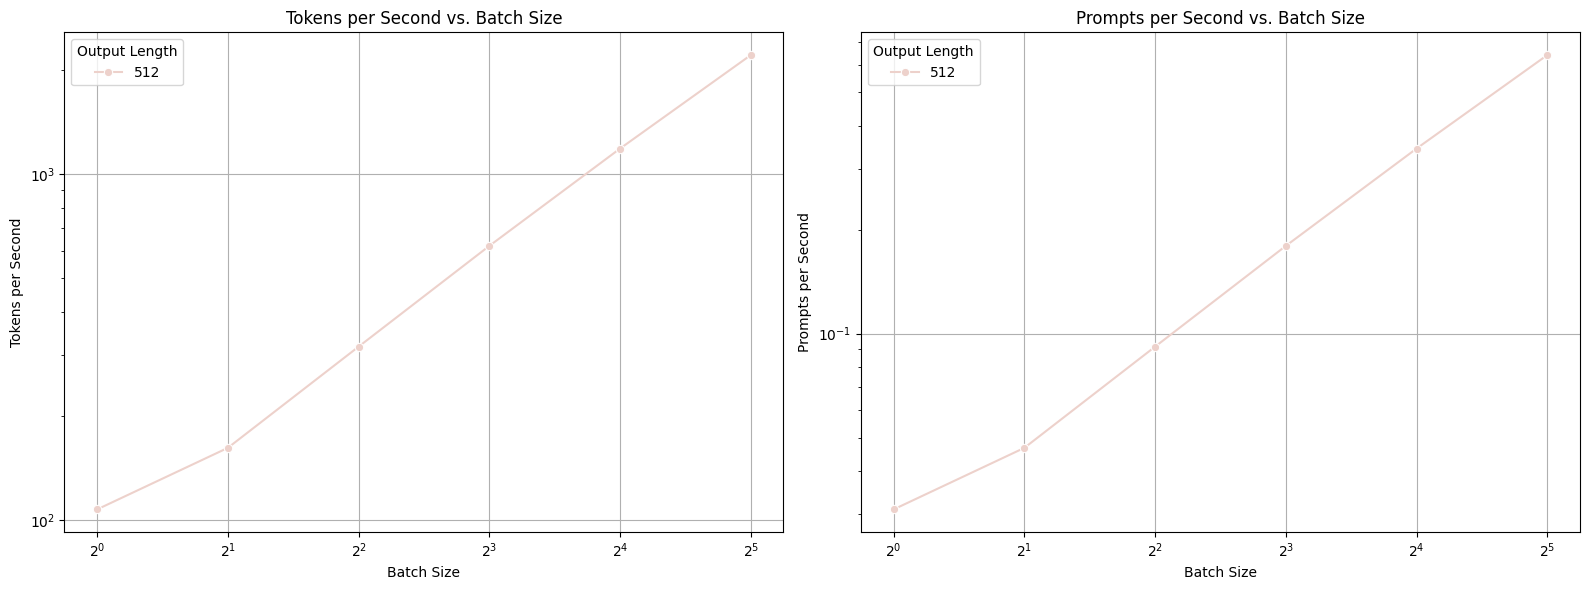

In [30]:
#@title Throughput By Batch Size {display-mode: "form"}

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Convert the batch_metrics dictionary to a list of dictionaries for easier DataFrame creation
data = []
for (batch_size, output_ids_len), metrics in batch_metrics.items():
    data.append({
        "batch_size": batch_size,
        "output_ids_len": output_ids_len,
        "tok_per_sec": metrics["tok_per_sec"],
        "prompt_per_sec": metrics["prompt_per_sec"]
    })

# Create a pandas DataFrame
batch_metrics_df = pd.DataFrame(data)

# Create a figure with two subplots (panes)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Tokens per Second on the first subplot
sns.lineplot(data=batch_metrics_df, x='batch_size', y='tok_per_sec', hue='output_ids_len', marker='o', ax=axes[0])
axes[0].set_title('Tokens per Second vs. Batch Size')
axes[0].set_xlabel('Batch Size')
axes[0].set_ylabel('Tokens per Second')
axes[0].grid(True)
axes[0].set_xscale('log', base=2) # Use log scale for batch size
axes[0].set_yscale('log') # Use log scale for throughput
axes[0].legend(title='Output Length')

# Plot Prompts per Second on the second subplot
sns.lineplot(data=batch_metrics_df, x='batch_size', y='prompt_per_sec', hue='output_ids_len', marker='o', ax=axes[1])
axes[1].set_title('Prompts per Second vs. Batch Size')
axes[1].set_xlabel('Batch Size')
axes[1].set_ylabel('Prompts per Second')
axes[1].grid(True)
axes[1].set_xscale('log', base=2) # Use log scale for batch size
axes[1].set_yscale('log') # Use log scale for throughput
axes[1].legend(title='Output Length')

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

### Beyond batching with `transformers`

We've seen above about how performance can be effectively scaled (to a point) by different batching strategies.  One downside of how `transformers` handles this is that all prompts must be assembed into a batch at call-time.  Other libraries that are optimized for serving at scale, like [vLLM (continuous batching)](https://docs.vllm.ai/en/latest/), [SGLang(continuous batching)](https://docs.sglang.ai/) or [TRT-LLM (IFB/continuous batching)](https://developer.nvidia.com/blog/nvidia-tensorrt-llm-now-accelerates-encoder-decoder-models-with-in-flight-batching/) offer different batching strategies that are more flexible, and can still perform batch inference even if prompts do not arrive synchronously.


We'll talk more about this more optimized infrastructure in Parts 3+4!

## Thanks for Reading!

Any questions / comments / improvements can be left via github issues, or contacting via github user [`b-koopman`](https://github.com/b-koopman).